In [10]:
import os
import json
import seaborn as sns
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt

from models.ep_nn import load_model
from tqdm import tqdm
from itertools import product

In [11]:
mat_name = 'isotropic-swift'
train_inp_name = 'pd_ms_42_200'

eval_inp_names = ['amplitude','cyclic','impulse','piecewise','resolution','bl_ms_42_200','gp_42_200','rw_42_200']
cols = ['name','network','output_type','k','p','q','seed','num_params']

model_folder = osp.join('metrics',mat_name,train_inp_name)
model_names = os.listdir(model_folder)

In [12]:
results_glob, results_loc = [], []

for model_name in tqdm(model_names):
    
    model = load_model(osp.join(model_folder,model_name,'model.pth'))
    
    line_glob = [
        model.name,
        model.network_name, 
        model.output_type_name, 
        model.k,
        model.p,
        model.q,
        model.seed,
        model.num_params
    ]
    line_loc = line_glob.copy()
    

    eval_metrics_path = osp.join(
        model_folder,
        model_name,
        'eval_metrics.json',
    )
    
    with open(eval_metrics_path,'rb') as f:
        error_metrics = json.load(f)
    
    for eval_inp_name in eval_inp_names:

        line_glob.append(error_metrics[eval_inp_name]['global']['MSE_rel'])
        line_loc.append(error_metrics[eval_inp_name]['local']['MSE_rel'])

    results_glob.append(line_glob)
    results_loc.append(line_loc)


df_glob = pd.DataFrame(results_glob, columns=cols+eval_inp_names)
df_loc = pd.DataFrame(results_loc, columns=cols+eval_inp_names)

100%|██████████| 185/185 [00:07<00:00, 24.08it/s]


Plot the top 3 surrogate models on piecewise set (based on global and local error)

In [13]:
display(df_glob.sort_values('piecewise')[:3][['name','piecewise']])
display(df_loc.sort_values('piecewise')[:3][['name','piecewise']])

,name,piecewise
97,MLP-dir-5-5-3-83,0.011739
80,MLP-dir-3-5-2-17,0.011776
129,MLP-incr-2-5-3-75,0.012095


,name,piecewise
146,MLP-incr-3-5-5-29,0.000036
175,MLP-incr-8-3-5-64,0.000038
180,MLP-incr-8-5-8-17,0.000050


They aren't same

/tmp/ipykernel_1939/399239170.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_MLP_dir = df_glob[df_glob['network'] == network_name][df_glob['output_type'] == output_type]


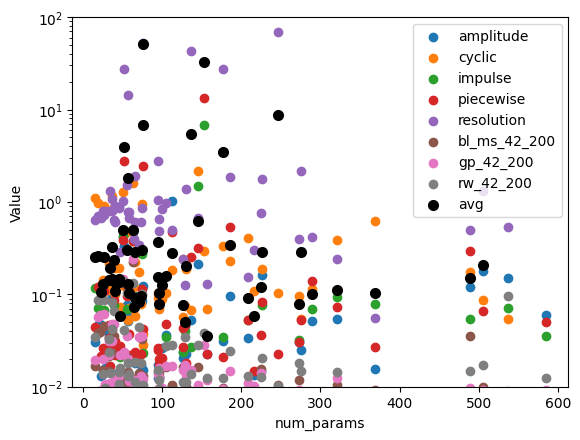

In [14]:
network_name = 'MLP'
output_type = 'incr'
param = 'num_params'


df_MLP_dir = df_glob[df_glob['network'] == network_name][df_glob['output_type'] == output_type]
df_MLP_dir = df_MLP_dir[['name',param]+eval_inp_names]
df_MLP_dir = df_MLP_dir.sort_values(param)
df_MLP_dir['avg_error'] = df_MLP_dir[eval_inp_names].mean(axis=1)


for eval_inp_name in eval_inp_names:
    plt.scatter(
        df_MLP_dir[param],
        df_MLP_dir[eval_inp_name],
        label=eval_inp_name,
        lw=1
    )

plt.scatter(
    df_MLP_dir[param],
    df_MLP_dir['avg_error'],
    label='avg',
    color='black',
    lw=2
)


plt.xlabel(param)
plt.yscale('log')
plt.ylim(0.01,100)
plt.ylabel("Value")
plt.legend()
plt.show()

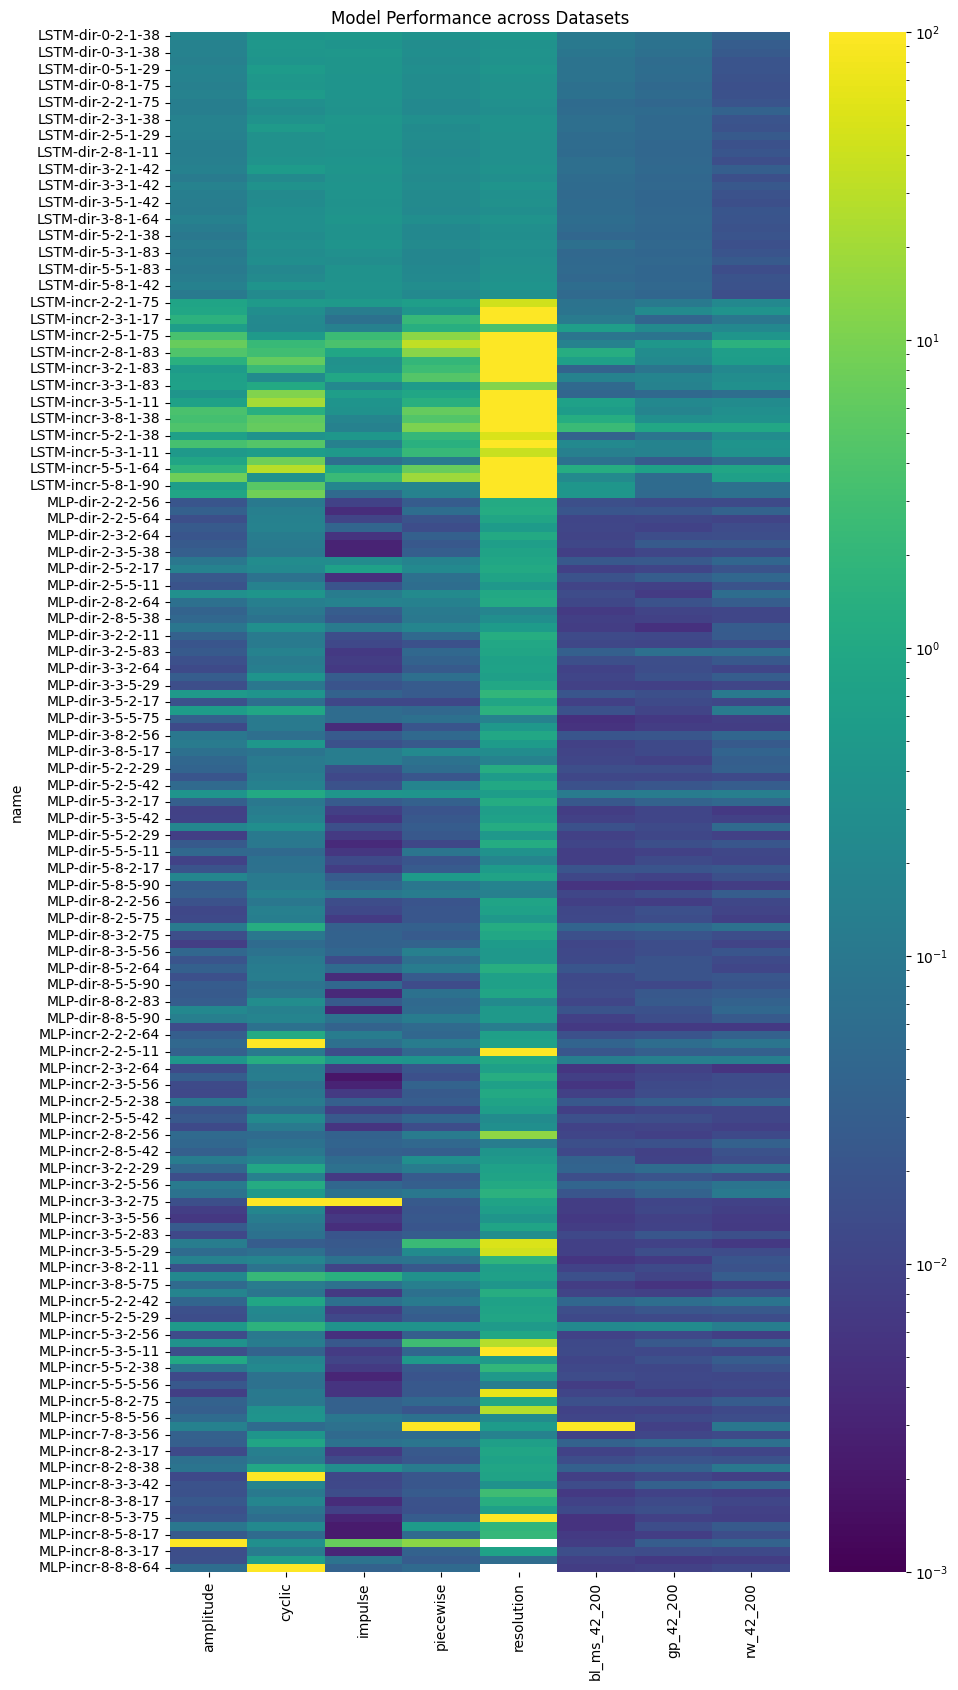

In [15]:
import seaborn as sns
from matplotlib.colors import LogNorm

df = df_glob[['name'] + eval_inp_names]
plt.figure(figsize=(10, 20))
sns.heatmap(
    df.set_index('name'), 
    cmap='viridis', 
    cbar=True,
    norm=LogNorm(vmin=1e-3, vmax=1e2)
)
plt.title("Model Performance across Datasets")
plt.show()

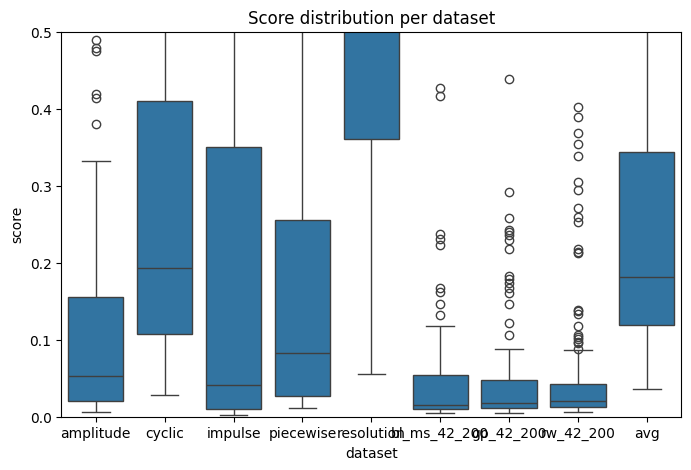

In [19]:
df_melted = df.melt(id_vars='name', var_name='dataset', value_name='score')

plt.figure(figsize=(8, 5))
sns.boxplot(x='dataset', y='score', data=df_melted)
plt.title("Score distribution per dataset")
plt.ylim(0,0.5)
plt.show()

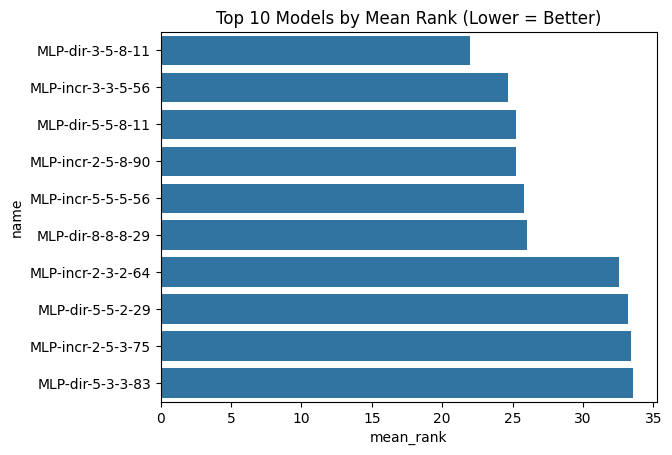

,name,amplitude,cyclic,impulse,piecewise,resolution,bl_ms_42_200,gp_42_200,rw_42_200,avg
83,MLP-dir-3-5-8-11,0.013498,0.108434,0.004127,0.020746,0.464940,0.005392,0.007699,0.007607,0.079055
93,MLP-dir-5-3-3-83,0.009081,0.127903,0.008466,0.019814,0.604139,0.007587,0.010788,0.006908,0.099336
96,MLP-dir-5-5-2-29,0.008291,0.107314,0.006957,0.022983,0.465863,0.009190,0.011509,0.009120,0.080153
99,MLP-dir-5-5-8-11,0.009760,0.072983,0.013544,0.020587,0.185073,0.008115,0.013217,0.010567,0.041731
119,MLP-dir-8-8-8-29,0.013938,0.074758,0.037691,0.051098,0.124248,0.006904,0.007051,0.006624,0.040289
124,MLP-incr-2-3-2-64,0.013157,0.119400,0.007833,0.021410,0.669539,0.005992,0.009110,0.005745,0.106523
129,MLP-incr-2-5-3-75,0.018026,0.057733,0.008093,0.012095,0.606827,0.008466,0.010823,0.011113,0.091647
131,MLP-incr-2-5-8-90,0.013320,0.108256,0.005678,0.014844,0.298404,0.009676,0.010302,0.008918,0.058675
142,MLP-incr-3-3-5-56,0.006484,0.120428,0.006468,0.022471,0.398614,0.006837,0.009161,0.007317,0.072223
162,MLP-incr-5-5-5-56,0.022515,0.068705,0.005588,0.022398,0.130910,0.007816,0.011743,0.012549,0.035278


In [20]:
df_rank = df[df.columns[1:]].rank(axis=0, ascending=True)
df_rank['mean_rank'] = df_rank.mean(axis=1)
df_rank['name'] = df['name']

top = df_rank.sort_values('mean_rank').head(10)
sns.barplot(y='name', x='mean_rank', data=top)
plt.title("Top 10 Models by Mean Rank (Lower = Better)")
plt.show()

df[df['name'].isin(top['name'])]

/tmp/ipykernel_1939/2356042535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'avg'] = df[eval_inp_names].mean(axis=1)


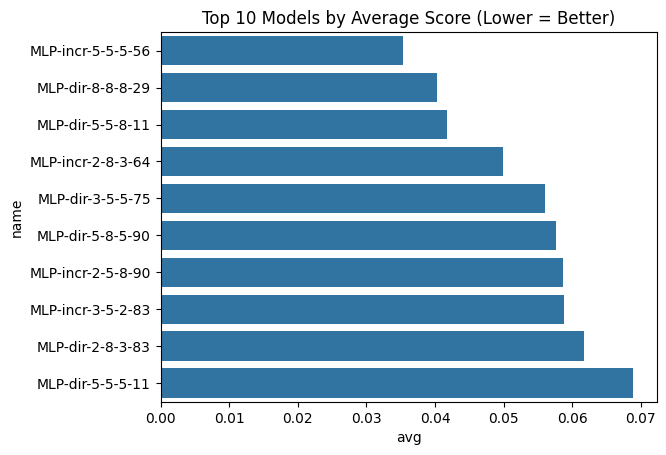

,name,amplitude,cyclic,impulse,piecewise,resolution,bl_ms_42_200,gp_42_200,rw_42_200,avg
162,MLP-incr-5-5-5-56,0.022515,0.068705,0.005588,0.022398,0.130910,0.007816,0.011743,0.012549,0.035278
119,MLP-dir-8-8-8-29,0.013938,0.074758,0.037691,0.051098,0.124248,0.006904,0.007051,0.006624,0.040289
99,MLP-dir-5-5-8-11,0.009760,0.072983,0.013544,0.020587,0.185073,0.008115,0.013217,0.010567,0.041731
133,MLP-incr-2-8-3-64,0.045570,0.074520,0.039774,0.046818,0.124954,0.016021,0.017017,0.034221,0.049862
82,MLP-dir-3-5-5-75,0.032727,0.112303,0.056133,0.066301,0.160875,0.005042,0.006810,0.008398,0.056074
102,MLP-dir-5-8-5-90,0.026698,0.109253,0.044733,0.090682,0.170763,0.005659,0.005962,0.007661,0.057677
131,MLP-incr-2-5-8-90,0.013320,0.108256,0.005678,0.014844,0.298404,0.009676,0.010302,0.008918,0.058675
144,MLP-incr-3-5-2-83,0.011964,0.073279,0.020974,0.027618,0.286398,0.011986,0.022112,0.015777,0.058763
69,MLP-dir-2-8-3-83,0.037275,0.102182,0.028220,0.110940,0.187723,0.007011,0.009926,0.011013,0.061786
98,MLP-dir-5-5-5-11,0.046133,0.048880,0.006071,0.087835,0.332897,0.008227,0.009333,0.011660,0.068880


In [18]:
# Compute the average score across columns (excluding 'name')
df.loc[:, 'avg'] = df[eval_inp_names].mean(axis=1)

# Select the top 10 models with highest average score
top = df.sort_values('avg', ascending=True).head(10)

# Plot
sns.barplot(y='name', x='avg', data=top)
plt.title("Top 10 Models by Average Score (Lower = Better)")
plt.show()
top